# Convex Optimization

## Homework 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

In [2]:
def primal(w, X, y, reg=10):
    return .5 * np.linalg.norm(X @ w - y, 2)**2 + reg * np.linalg.norm(w, 1)


def dual(v, Q, p):
    return v.T @ Q @ v + p.T @ v


# with log barrier
def objective(v, Q, p, A, b, t):
    if np.any(b - A @ v <= 0):
        return float("NaN")
    return t * (v.T @ Q @ v + p.T @ v) - np.sum(np.log(b - A @ v))


def gradient(v, Q, p, A, b, t):
    phi = 1. / (b - A @ v)
    return t * (2 * Q @ v + p) + A.T @ phi


def hessian(v, Q, p, A, b, t):
    phi = 1. / (b - A @ v)
    return 2 * t * Q + A.T @ np.diag(phi)**2 @ A

In [3]:
def line_search(f, grad_f, v, dv, alpha=.5, beta=.9):
    step = 1

    while f(v + step * dv) > f(v) + alpha * step * grad_f(v).T @ dv and step > 1e-6:
        step *= beta
        
        if np.any(b - A @ (v + step * dv) <= 0):
            return step

    return step


def centering_step(Q, p, A, b, t, v0, eps=1e-9, alpha=.5, beta=.9, max_iter=500):
    """See question 2."""

    # to simplify notations
    obj = lambda v: objective(v, Q, p, A, b, t)
    grad = lambda v: gradient(v, Q, p, A, b, t)
    hess = lambda v: hessian(v, Q, p, A, b, t)

    # initialization
    v_seq = [v0]
    v = v0
    i = 0

    while i < max_iter:
        i += 1
        
        # Newton's method
        dv = np.linalg.pinv(hess(v)) @ grad(v)
        step = line_search(obj, grad, v, dv, alpha=alpha, beta=beta)
        v = v - step * dv
        v_seq.append(v)
        
        # stopping criterion
        l = grad(v).T @ dv
        if l < 2 * eps:
            break

    return v_seq


def barr_method(Q, p, A, b, v0, mu, eps=1e-9, alpha=.5, beta=.9, max_iter=500):
    """See question 2."""
    
    # initialization
    v_seq = [v0]
    t = 1
    m = len(A)

    while m/t > eps:
        x = centering_step(Q, p, A, b, t, v_seq[-1], eps=eps, alpha=alpha, beta=beta, max_iter=max_iter)[-1]
        v_seq.append(x)

        t *= mu

    return v_seq


def generate_parameters(n, d, reg=10):
    """See question 3."""
    
    X = 3 * np.random.randn(n, d)
    y = 5 + 1.5 * np.random.randn(n)

    Q = np.eye(n) / 2
    p = - y

    A = np.concatenate((X.T, - X.T), axis=0)
    b = reg * np.ones(2 * d)

    v0 = np.zeros(n)

    return X, y, Q, p, A, b, v0

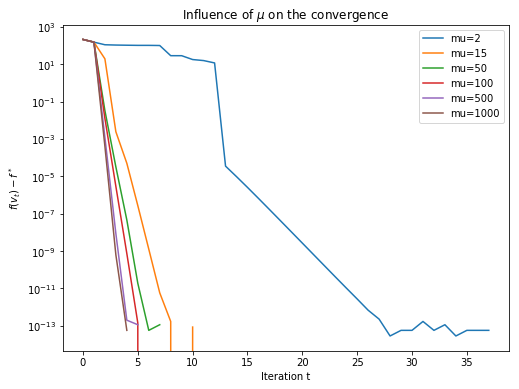

In [4]:
n, d, reg = 20, 50, 10
X, y, Q, p, A, b, v0 = generate_parameters(n, d, reg)
eps = 1e-9
alpha, beta = .5, .9
max_iter = 500

mu_values = [2, 15, 50, 100, 500, 1000]
results = [barr_method(Q, p, A, b, v0, mu, eps, alpha, beta, max_iter) for mu in mu_values]
f_values = [[dual(v, Q, p) for v in results[i]] for i in range(len(results))]
f_star = np.infty
for i in range(len(results)):
    for v in f_values[i]:
        if f_star > v:
            f_star = v

plt.figure(figsize=(8, 6))
plt.xlabel('Iteration t')
plt.ylabel('$f(v_t) - f^*$')
plt.title('Influence of $\\mu$ on the convergence')
for i in range(len(results)):
    plt.semilogy(f_values[i] - f_star, label='mu={}'.format(mu_values[i]))
plt.legend()
plt.show()